In [119]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize']=(10.0,8.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
% %matplotlib inline

## Prepare Data Set

In [120]:
mnist_data_path='../AI_database/mnist/MNIST_DATA'
def imshow(X,Y=None,classes=None):
    '''
        show Batch of image in grids sqrt(h) x sqrt(w)
        X is a numpy array,size (m,h,w,c)
        Y is a numpy array,size (m,#classes)
    '''
    m=X.shape[0]
    gridSize=int(m**0.5)
    
    fig=plt.figure(figsize=(gridSize,gridSize))
    gs=gridspec.GridSpec(gridSize,gridSize)
    gs.update(wspace=0.05,hspace=0.05)
    for i in range(0,gridSize):
        for j in range(0,gridSize):
            _idx=i*gridSize+j
            im=X[_idx]
            plt.subplot(gridSize,gridSize,_idx+1)
            plt.axis('off')
            plt.imshow(im)
            if Y is not None:
                label=classes[np.argmax(Y[_idx])]
                plt.title(label)
    return fig
def load_dataset(flaten=False,one_hot=True):
    def _make_one_hot(d,C=10):
        return (np.arange(C)==d[:,None]).astype(np.int32)

    mnist=input_data.read_data_sets(mnist_data_path)
    X_train,Y_train=mnist.train.images,mnist.train.labels
    X_test,Y_test=mnist.test.images,mnist.test.labels

    if flaten==False:
        X_train=X_train.reshape((-1,28,28,1))
        X_test = X_test.reshape((-1, 28, 28,1))
    if one_hot:
        Y_train = _make_one_hot(Y_train)
        Y_test=_make_one_hot(Y_test)


    print('\n-------------------------------------------------------------------------')
    print('load %d train Example,%d Test Example'%(X_train.shape[0],X_test.shape[0]))
    print('Train Images  Shape:'+str(X_train.shape))
    print('Train Labels  Shape:' + str(Y_train.shape))
    print('Test  Images  Shape:'+str(X_test.shape))
    print('Test  Labels  Shape:' + str(Y_test.shape))
    print('-------------------------------------------------------------------------')
    return (X_train,Y_train,X_test,Y_test)

In [121]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return fig

In [122]:
def get_session():
    config=tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess=tf.Session(config=config)
    return sess

In [123]:
X_train,Y_train,X_test,Y_test=load_dataset(flaten=True,one_hot=True)

Extracting ../AI_database/mnist/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-labels-idx1-ubyte.gz

-------------------------------------------------------------------------
load 55000 train Example,10000 Test Example
Train Images  Shape:(55000, 784)
Train Labels  Shape:(55000, 10)
Test  Images  Shape:(10000, 784)
Test  Labels  Shape:(10000, 10)
-------------------------------------------------------------------------


## Define Gans Model

In [138]:
class GANS():
    def __init__(self,n_x=784,n_z=784,seed=None):
        self.disScope='discriminator'
        self.genScope='generate'
        
        self.n_x=n_x
        self.n_z=n_z
        self.seed=None
        
    def _discriminator(self,X):
        '''
            X--->X(256)--->X(256)--->X(1)
        '''
        with tf.variable_scope(self.disScope,reuse=tf.AUTO_REUSE):
            X=tf.layers.dense(X,256,
                #kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)
                             )
            X=tf.nn.leaky_relu(X,alpha=0.01)
            
            X=tf.layers.dense(X,256,
                #kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)
                             )
            X=tf.nn.leaky_relu(X,alpha=0.01)
            
            logit=tf.layers.dense(X,1)
        return logit
    def _generator(self,Z):
        '''
            Z--->X(1024)-->X(1024)-->X(n_x)->tanh
        '''
        with tf.variable_scope(self.genScope,reuse=tf.AUTO_REUSE):
            X=tf.layers.dense(Z,1024,activation=tf.nn.relu,
                              #kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)
                             )
            X=tf.layers.dense(X,1024,activation=tf.nn.relu,
                              #kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)
                             )
            X=tf.layers.dense(X,self.n_x,
                              activation=tf.tanh,
                              #kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=self.seed)
                             )
        return X
                              
    def model(self,X,Z):
        '''
            X: a image,shape [batch,n_x]
            Z: latent variable,shape[batch,n_z]
            return logit_real,logit_fake,G_sample
        '''
        logit_real=self._discriminator(2*X-1.0)

        G_Sample=self._generator(Z)
        logit_fake=self._discriminator(G_Sample)
        
        return logit_real,logit_fake,G_Sample
    
    def loss(self,logit_real,logit_fake):
        '''
            compute loss for discriminator D_loss
            and loss for generator G_loss
            
            D_loss=-mean(single_entropy([logit_real,logit_fake],[1,0]))
            G_loss=-mean(single_entropy(logit_fake,1))
        '''
    
        #Discriminator Loss
        label_real = tf.ones_like(logit_real)
        label_fake = tf.zeros_like(logit_fake)
        
        D_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_real, labels=label_real)
        D_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_fake, labels=label_fake)
        D_loss=tf.reduce_mean(D_loss_real+D_loss_fake)
        
        G_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_fake,labels=tf.ones_like(logit_fake)))
        G_loss=tf.reduce_mean(-tf.log(tf.nn.sigmoid(logit_fake)))

        return D_loss,G_loss
    
    def buildModel(self,batch=128,lr=1e-3,beta1=0.5):
        '''
            for entile model for training:
            1.input layer :X(n_x),Z(n_x)
            2.model struct  model(X,Z)=logit_real,logit_fake,G_Sample 
            3.loss: loss(logit_real,logit_fake)=D_loss,G_loss
            4.build 2 optimizer D_opmizer,G_optimizer,wrt var_list
            
            return X,D_loss,G_loss,D_opmizer,G_optimizer,G_Sample
        '''
        
        #step 1
        X=tf.placeholder(shape=[batch,self.n_x],dtype=tf.float32)
        Z=tf.random_uniform((batch,self.n_z),-1,1,dtype=tf.float32,seed=self.seed)
        #step2
        logit_real,logit_fake,G_Sample=self.model(X,Z)
        #step3
        D_loss,G_loss=self.loss(logit_real,logit_fake)
        #step4
        D_vars=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.disScope)
        G_vars=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.genScope)


        D_optimizer=tf.train.AdamOptimizer(lr,beta1=beta1).minimize(D_loss,var_list=D_vars)
        G_optimizer=tf.train.AdamOptimizer(lr,beta1=beta1).minimize(G_loss,var_list=G_vars)
        
        return (X,D_loss,G_loss,D_optimizer,G_optimizer,G_Sample)
    
    def fit(self,sess,Xd,batch=128,epoch=10,lr=1e-3,beta1=0.5,print_every=50,show_every=250):
        
        #prepare the miniBatch Data,defina a generator
        def miniBatch(Xd,batch):
            m=len(Xd)
            if m%batch>0:Xd=Xd[:-(m%batch)]
            m=len(Xd)
            i=0
            while True:
                start=(i*batch)%m
                end=batch+start
                yield Xd[start:end]
                i+=1
        gen=miniBatch(Xd,batch)
        #build the Network
        
        X,D_loss,G_loss,D_Optimizer,G_optimizer,G_Sample=self.buildModel(batch,lr,beta1)
        
        #begin training!
        max_iters=len(Xd)*epoch//batch
        sess.run(tf.global_variables_initializer())
        D_loss_history,G_loss_history=[],[]
        for it in range(max_iters):
            if it% show_every==0:
                d=self.n_x**0.5
                sample=sess.run(G_Sample)
                fig=show_images(sample[:16])
                fig.show()
                print()
            _,D_cost_curr=sess.run([D_Optimizer,D_loss],feed_dict={X:next(gen)})
            _,G_cost_curr=sess.run([G_optimizer,G_loss])
            
            D_loss_history.append(D_cost_curr)
            G_loss_history.append(G_cost_curr)
            

            if it%print_every==0:
                print( 'Iter:{}/{},D_loss:{:.4},G_loss:{:.4}'.format(it,max_iters,D_cost_curr,G_cost_curr))
        return D_loss_history,G_loss_history

In [139]:
net=GANS(n_x=784,n_z=96,seed=None)


Iter:0/4296,D_loss:1.211,G_loss:0.726
Iter:100/4296,D_loss:1.198,G_loss:1.181
Iter:200/4296,D_loss:0.9968,G_loss:1.795

Iter:300/4296,D_loss:1.28,G_loss:1.483
Iter:400/4296,D_loss:1.233,G_loss:1.004

Iter:500/4296,D_loss:1.52,G_loss:1.193
Iter:600/4296,D_loss:1.471,G_loss:1.437
Iter:700/4296,D_loss:1.336,G_loss:1.935

Iter:800/4296,D_loss:0.8243,G_loss:1.415
Iter:900/4296,D_loss:0.9981,G_loss:1.003

Iter:1000/4296,D_loss:1.104,G_loss:1.191
Iter:1100/4296,D_loss:1.18,G_loss:1.151
Iter:1200/4296,D_loss:0.9651,G_loss:1.847

Iter:1300/4296,D_loss:1.374,G_loss:1.015
Iter:1400/4296,D_loss:1.146,G_loss:1.375

Iter:1500/4296,D_loss:1.067,G_loss:1.335
Iter:1600/4296,D_loss:1.288,G_loss:0.8111
Iter:1700/4296,D_loss:1.08,G_loss:1.574

Iter:1800/4296,D_loss:1.175,G_loss:0.9881
Iter:1900/4296,D_loss:1.245,G_loss:0.834

Iter:2000/4296,D_loss:1.348,G_loss:0.8667
Iter:2100/4296,D_loss:1.329,G_loss:0.8743
Iter:2200/4296,D_loss:1.197,G_loss:0.8498

Iter:2300/4296,D_loss:1.29,G_loss:0.856
Iter:2400/4296

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


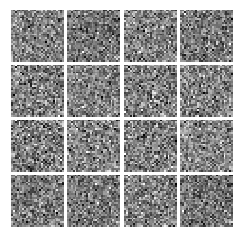

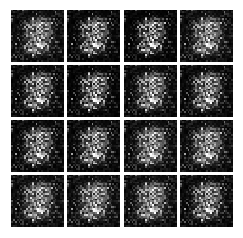

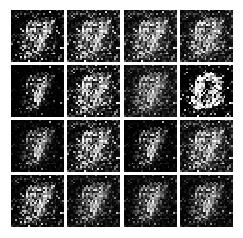

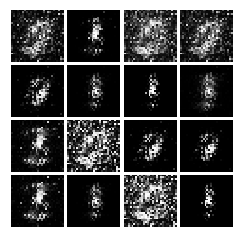

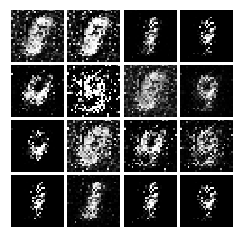

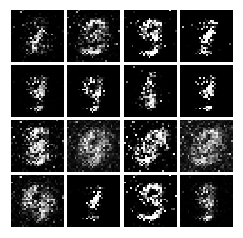

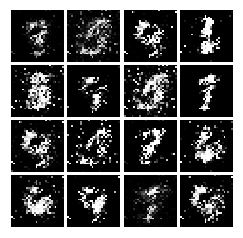

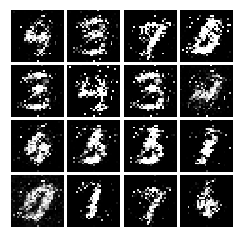

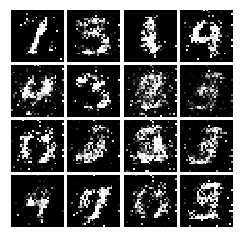

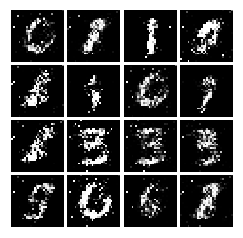

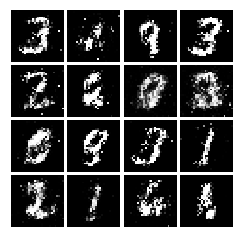

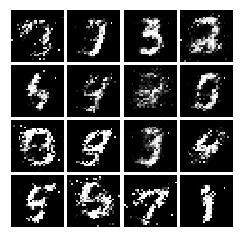

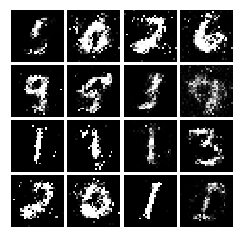

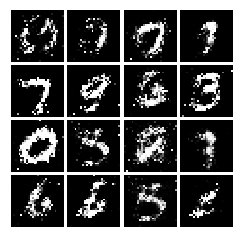

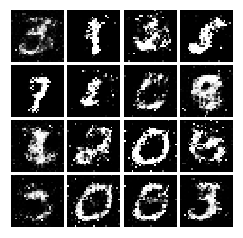

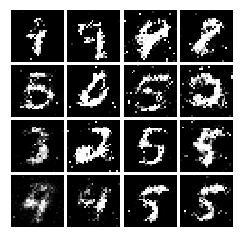

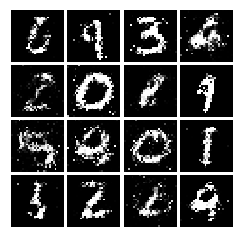

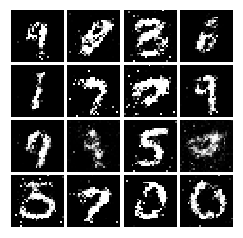

In [140]:
tf.reset_default_graph()
sess=get_session()
his_d_loss,his_g_loss=net.fit(sess,X_train,batch=128,epoch=10,lr=1e-3,beta1=0.5,print_every=100,show_every=250)
sess.close()

In [ ]:
plt.subplot(1,2,1)
plt.plot(his_d_loss)
plt.title('d_loss')

plt.subplot(1,2,2)
plt.plot(his_g_loss)
plt.title('g_loss')
# for i in range(10):
#     if(i %2==0):
#         imshow(X_train[:16].reshape(-1,28,28))
#     print('ss')

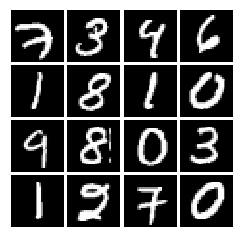

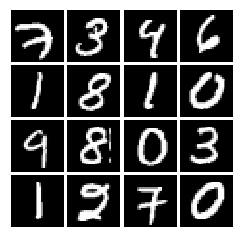

In [95]:
show_images(X_train[:16])